<a href="https://colab.research.google.com/github/iuricimatec/depthmap/blob/main/EDA_motor_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The dataset was extracted from images using opencv

First, the Canny algorithm were used to detect the robot's edges. After obtaining the robot's skeleton, many features were extracted, such as:

 - The size of the perimeter in which the robot is inside;
 - The angle of the ellipsis in which the robot is inside;
 - the radius of the circulus in which the robot is inside;
 - etc...

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold


# to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/CIMATEC/MCTI/BOLSA/SoftArm/dataset/EDA/'

Mounted at /content/gdrive


In [3]:
sns.__version__

'0.12.2'

In [4]:
df = pd.read_csv(path+ "input/dataset_motor_features.csv", index_col=None)
df.head()


,10,10.1,10.2,10.3,10.4,10.5,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,...,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief,cam3_orb
0,10,10,10,10,10,10,1047.0,125.5,51.21,86.2,...,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0,500.0
1,10,10,10,10,10,10,1047.0,125.5,51.21,86.2,...,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0,500.0
2,10,10,10,10,10,10,1047.0,125.5,51.21,86.2,...,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0,500.0
3,10,10,10,10,10,10,1035.0,0.0,0.00,0.0,...,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0,500.0
4,10,10,10,10,10,10,1035.0,0.0,0.00,0.0,...,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0,500.0


In [5]:
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
# Checking wether there's nan values
print('Is there any NaN value in the data? ', np.any(np.isnan(df))) #and gets False
print('Is all data finite? ', np.all(np.isfinite(df))) #and gets True

# df = df.reset_index()
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# running the function
clean_dataset(df)    
# Checking wether there's nan values
print('Is there any NaN value in the data? ', np.any(np.isnan(df))) #and gets False
print('Is all data finite? ', np.all(np.isfinite(df))) #and gets True

Is there any NaN value in the data?  True
Is all data finite?  False
Is there any NaN value in the data?  False
Is all data finite?  True


In [6]:
df.shape
df.columns

Index(['10', '10.1', '10.2', '10.3', '10.4', '10.5', 'cam1_canny', 'cam1_area',
       'cam1_perimeter', 'cam1_angle', 'cam1_rect_straigth_area',
       'cam1_rect_straigth_perimeter', 'cam1_rect_rotated_area',
       'cam1_rect_rotated_perimeter', 'cam1_circle_area', 'cam1_circle_radius',
       'cam1_ellipse_area', 'cam1_ellipse_perimeter', 'cam1_fast',
       'cam1_fast_no_supress', 'cam1_harris', 'cam1_shitomasi', 'cam1_brief',
       'cam1_orb', 'cam2_canny', 'cam2_area', 'cam2_perimeter', 'cam2_angle',
       'cam2_rect_straigth_area', 'cam2_rect_straigth_perimeter',
       'cam2_rect_rotated_area', 'cam2_rect_rotated_perimeter',
       'cam2_circle_area', 'cam2_circle_radius', 'cam2_ellipse_area',
       'cam2_ellipse_perimeter', 'cam2_fast', 'cam2_fast_no_supress',
       'cam2_harris', 'cam2_shitomasi', 'cam2_brief', 'cam2_orb', 'cam3_canny',
       'cam3_area', 'cam3_perimeter', 'cam3_angle', 'cam3_rect_straigth_area',
       'cam3_rect_straigth_perimeter', 'cam3_rect_rotated

In [7]:
#Storing the target fetures in a new variable
Y = df.iloc[:,:6]
Y.head()

,10,10.1,10.2,10.3,10.4,10.5
0,10,10,10,10,10,10
1,10,10,10,10,10,10
2,10,10,10,10,10,10
3,10,10,10,10,10,10
4,10,10,10,10,10,10


In [8]:
#Changing the target variables names
Y.columns = ["Engine"+ str(s) for s in range(1,7)]
Y.head()

,Engine1,Engine2,Engine3,Engine4,Engine5,Engine6
0,10,10,10,10,10,10
1,10,10,10,10,10,10
2,10,10,10,10,10,10
3,10,10,10,10,10,10
4,10,10,10,10,10,10


In [9]:
#Storing the input features in a new variable
X = df.iloc[:,6:]
X.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_area,cam1_rect_straigth_perimeter,cam1_rect_rotated_area,cam1_rect_rotated_perimeter,cam1_circle_area,cam1_circle_radius,...,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief,cam3_orb
0,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0,500.0
1,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0,500.0
2,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0,500.0
3,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,...,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0,500.0
4,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,...,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0,500.0


In [10]:
#Basic descriptive statistics for the input vatiables
X.describe()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_area,cam1_rect_straigth_perimeter,cam1_rect_rotated_area,cam1_rect_rotated_perimeter,cam1_circle_area,cam1_circle_radius,...,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief,cam3_orb
count,1047.000000,1047.000000,1047.000000,1047.00000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,...,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,842.638968,87.832378,41.835989,81.16361,145.621777,48.670487,117.406848,44.377498,227.005473,7.949343,...,227.005473,7.949343,107.024785,40.415272,5249.592168,5256.395415,204130.598854,192.286533,155.234957,497.555874
std,110.693346,54.754670,16.440936,20.63852,86.083990,17.255401,74.743415,17.182991,120.679286,3.012410,...,120.679286,3.012410,64.928771,15.811323,1680.805464,1680.155100,3565.468835,43.073263,61.665990,17.341207
min,539.000000,0.000000,0.000000,0.00000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000100,0.000000,0.000000,1051.000000,1051.000000,191762.000000,61.000000,31.000000,245.000000
25%,780.000000,26.500000,33.660000,80.90000,56.000000,40.000000,37.120000,36.000000,201.850000,8.015710,...,201.850000,8.015710,37.150000,30.260000,3902.500000,3904.000000,201667.000000,160.000000,111.000000,500.000000
50%,829.000000,102.500000,48.730000,86.00000,168.000000,56.000000,133.000000,51.271852,267.870000,9.233858,...,267.870000,9.233858,123.250000,46.940000,5168.000000,5168.000000,204151.000000,191.000000,146.000000,500.000000
75%,887.000000,112.500000,50.970000,89.10000,180.000000,58.000000,152.000000,54.000000,296.100000,9.708344,...,296.100000,9.708344,138.980000,49.660000,6397.000000,6397.000000,206882.000000,218.000000,189.000000,500.000000
max,1156.000000,370.000000,81.940000,134.00000,588.000000,98.000000,494.330000,89.959639,644.820000,14.326649,...,644.820000,14.326649,420.890000,74.980000,9060.000000,9060.000000,212064.000000,314.000000,319.000000,500.000000


In [11]:
#Unique values presented in each feature
for column in X.columns:
    print(f"{column}: {X[column].nunique()}")
    print("===========================================")

cam1_canny: 227
cam1_area: 145
cam1_perimeter: 93
cam1_angle: 178
cam1_rect_straigth_area: 59
cam1_rect_straigth_perimeter: 35
cam1_rect_rotated_area: 101
cam1_rect_rotated_perimeter: 97
cam1_circle_area: 121
cam1_circle_radius: 128
cam1_ellipse_area: 326
cam1_ellipse_perimeter: 317
cam1_fast: 339
cam1_fast_no_supress: 338
cam1_harris: 338
cam1_shitomasi: 139
cam1_brief: 181
cam1_orb: 22
cam2_canny: 227
cam2_area: 145
cam2_perimeter: 93
cam2_angle: 178
cam2_rect_straigth_area: 59
cam2_rect_straigth_perimeter: 35
cam2_rect_rotated_area: 101
cam2_rect_rotated_perimeter: 97
cam2_circle_area: 121
cam2_circle_radius: 128
cam2_ellipse_area: 326
cam2_ellipse_perimeter: 317
cam2_fast: 339
cam2_fast_no_supress: 338
cam2_harris: 338
cam2_shitomasi: 139
cam2_brief: 181
cam2_orb: 22
cam3_canny: 227
cam3_area: 145
cam3_perimeter: 93
cam3_angle: 178
cam3_rect_straigth_area: 59
cam3_rect_straigth_perimeter: 35
cam3_rect_rotated_area: 101
cam3_rect_rotated_perimeter: 97
cam3_circle_area: 121
cam3_circ

## Removing low-variance features

In [12]:
#Scaling the data between 0 and 1.
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_area,cam1_rect_straigth_perimeter,cam1_rect_rotated_area,cam1_rect_rotated_perimeter,cam1_circle_area,cam1_circle_radius,...,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief,cam3_orb
0,0.823339,0.339189,0.624969,0.643284,0.339012,0.595745,0.310299,0.614152,0.459198,0.67764,...,0.459198,0.67764,0.331227,0.647773,0.059933,0.949307,0.366565,0.956522,0.701389,1.0
1,0.823339,0.339189,0.624969,0.643284,0.339012,0.595745,0.310299,0.614152,0.459198,0.67764,...,0.459198,0.67764,0.331227,0.647773,0.949307,0.949307,0.366565,0.956522,0.701389,1.0
2,0.823339,0.339189,0.624969,0.643284,0.339012,0.595745,0.310299,0.614152,0.459198,0.67764,...,0.459198,0.67764,0.331227,0.647773,0.949307,0.949307,0.366565,0.956522,0.701389,1.0
3,0.803890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.940817,0.940817,0.320264,1.000000,0.722222,1.0
4,0.803890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.940817,0.940817,0.320264,1.000000,0.722222,1.0


In [13]:
#Features' variance
var = X_scaled.var().sort_values(ascending=True)
var

cam3_orb                        0.004625
cam1_orb                        0.004625
cam2_orb                        0.004625
cam2_rect_straigth_area         0.021506
cam1_rect_straigth_area         0.021506
cam3_rect_straigth_area         0.021506
cam2_area                       0.021900
cam3_area                       0.021900
cam1_area                       0.021900
cam3_rect_rotated_area          0.022862
cam2_rect_rotated_area          0.022862
cam1_rect_rotated_area          0.022862
cam3_angle                      0.023722
cam1_angle                      0.023722
cam2_angle                      0.023722
cam2_ellipse_area               0.023798
cam3_ellipse_area               0.023798
cam1_ellipse_area               0.023798
cam1_shitomasi                  0.028985
cam2_shitomasi                  0.028985
cam3_shitomasi                  0.028985
cam1_harris                     0.030843
cam2_harris                     0.030843
cam3_harris                     0.030843
cam3_canny      

cam3_orb                        0.004625
cam1_orb                        0.004625
cam2_orb                        0.004625
cam2_rect_straigth_area         0.021506
cam1_rect_straigth_area         0.021506
cam3_rect_straigth_area         0.021506
cam2_area                       0.021900
cam3_area                       0.021900
cam1_area                       0.021900
cam3_rect_rotated_area          0.022862
cam2_rect_rotated_area          0.022862
cam1_rect_rotated_area          0.022862
cam3_angle                      0.023722
cam1_angle                      0.023722
cam2_angle                      0.023722
cam2_ellipse_area               0.023798
cam3_ellipse_area               0.023798
cam1_ellipse_area               0.023798
cam1_shitomasi                  0.028985
cam2_shitomasi                  0.028985
cam3_shitomasi                  0.028985
cam1_harris                     0.030843
cam2_harris                     0.030843
cam3_harris                     0.030843
cam3_canny      

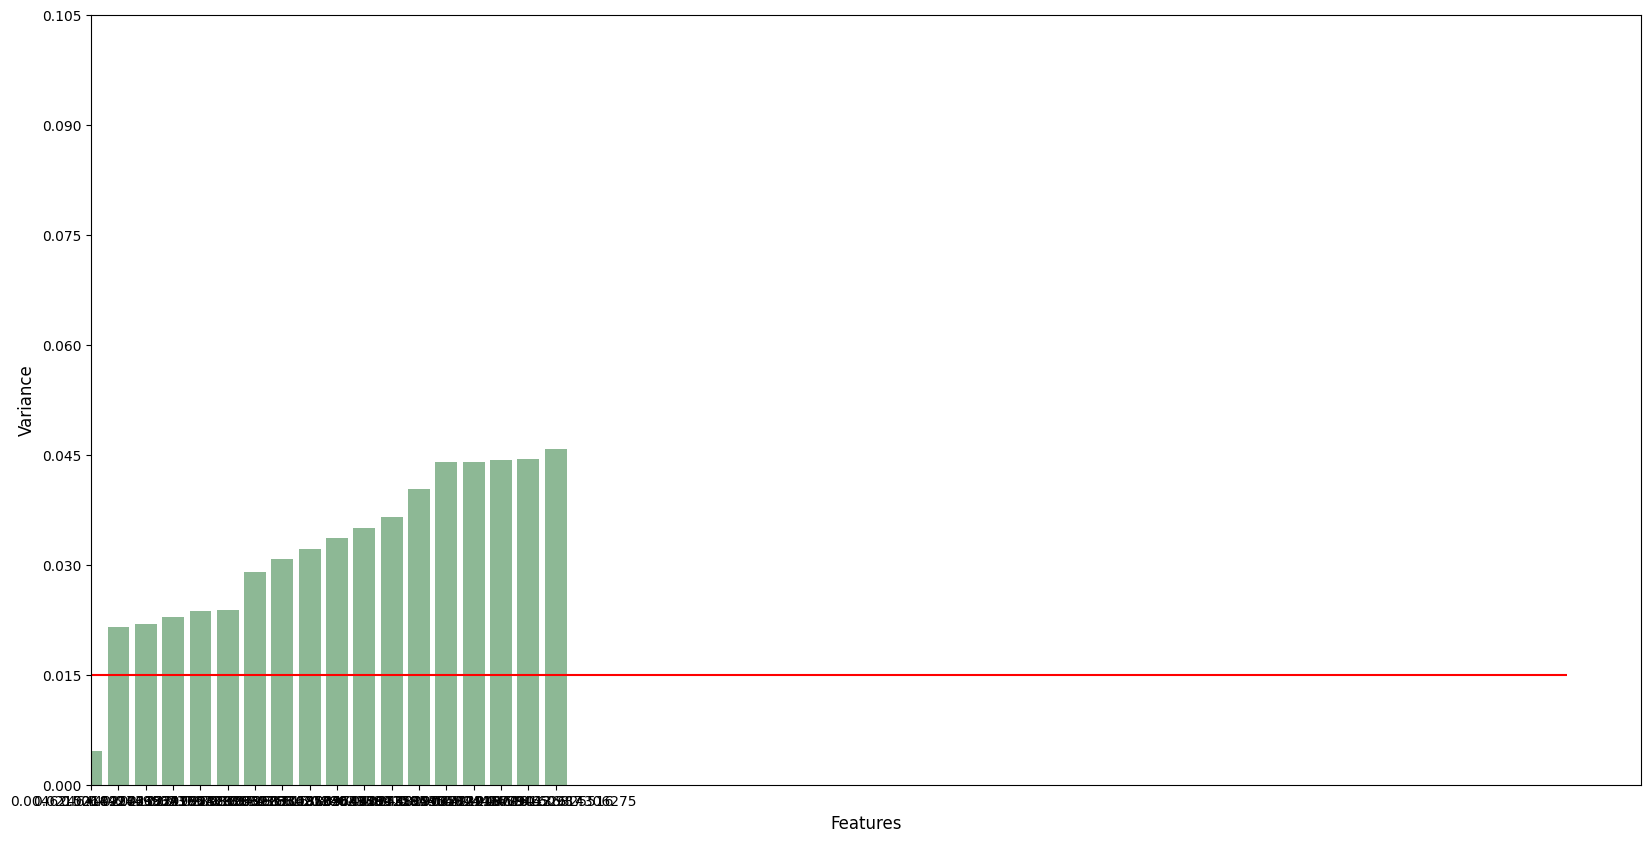

In [15]:
f, ax = plt.subplots(figsize = (20, 10))
g = sns.barplot(data=var, x=var.keys(), y=var.values, color='#86bf91', ax=ax);

plt.ylabel('Variance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.hlines(y=0.015, xmin=0, xmax=len(var), colors='red')
print(var)
#ax.set_xticklabels(var.keys(), rotation=45, fontsize=8, ha='right',  rotation_mode='anchor')

ax.set_yticks(np.arange(0, 0.10501, 0.015))
ax.set_xlim(0,);

In [16]:
#Using a variance threshold to filter out features with lower variances.
selector = VarianceThreshold(threshold=0.015)
X_out = selector.fit_transform(X_scaled)
X_out.shape

(1047, 51)

In [17]:
features_out = [col for col in X_scaled.columns if col not in selector.get_feature_names_out()]
features_out

['cam1_orb', 'cam2_orb', 'cam3_orb']

### Now, let's take a look at the distributions of the removed features

We can see that most of them exhibit a weird distribution, leptokurtic, as can be seen with `cam2_ellipse_area`,  `cam1_orb` and others.

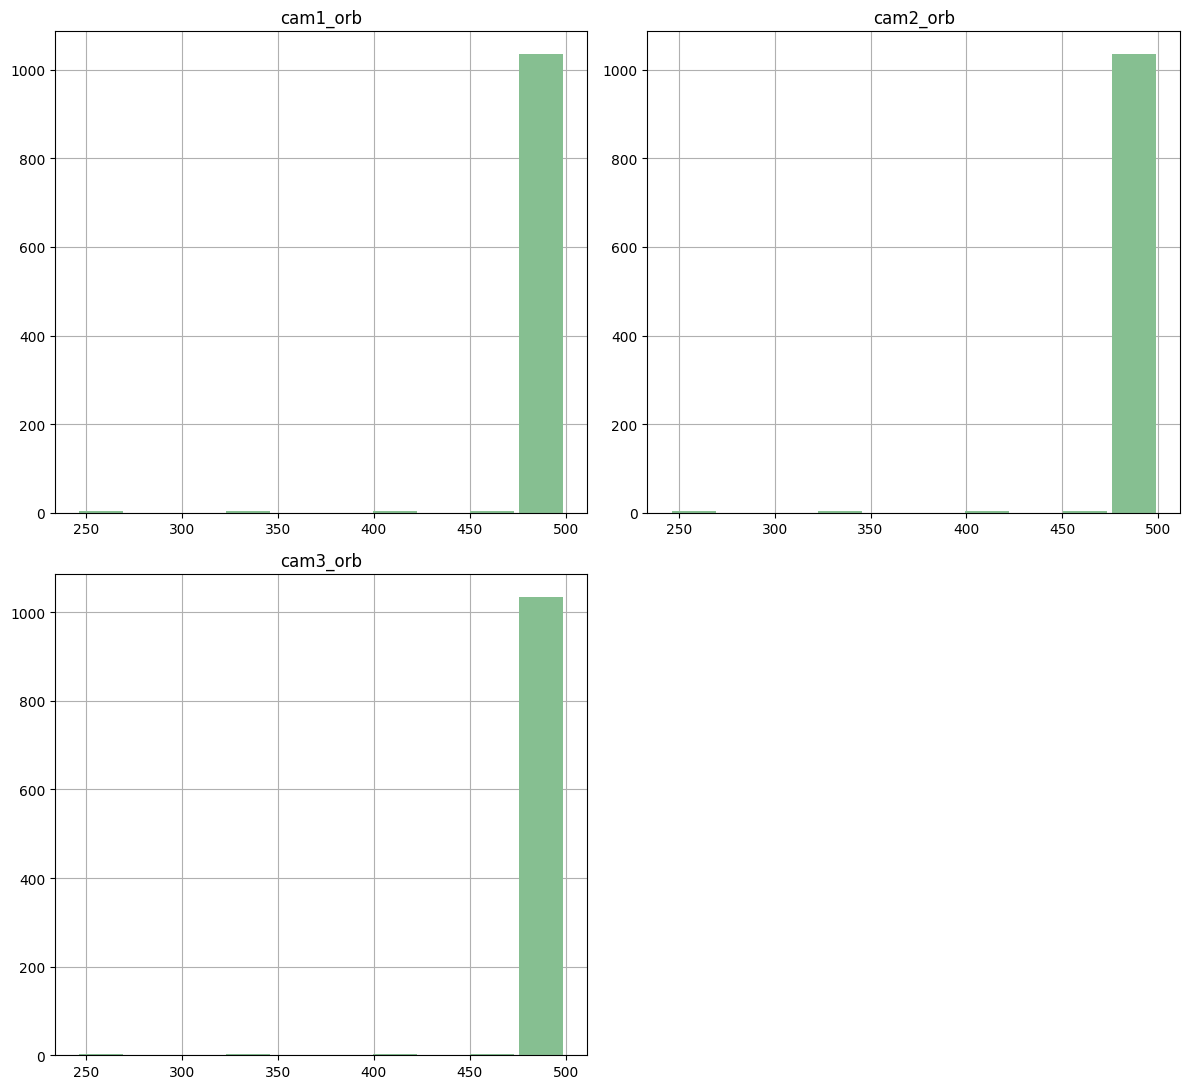

In [18]:
ax = X[features_out].hist(figsize=(12, 11), color='#86bf91', zorder=2, rwidth=0.9)
plt.tight_layout()

In [19]:
X.drop(features_out, axis=1, inplace=True)
X.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_area,cam1_rect_straigth_perimeter,cam1_rect_rotated_area,cam1_rect_rotated_perimeter,cam1_circle_area,cam1_circle_radius,...,cam3_rect_rotated_perimeter,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief
0,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,55.248914,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0
1,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
2,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,...,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
3,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,...,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0
4,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,...,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0


## Input data analysis 

In [20]:
# Camera 1 input data
cam1 = X[X.columns[X.columns.str.contains('cam1')]]
cam1.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_area,cam1_rect_straigth_perimeter,cam1_rect_rotated_area,cam1_rect_rotated_perimeter,cam1_circle_area,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,cam1_fast_no_supress,cam1_harris,cam1_shitomasi,cam1_brief
0,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0
1,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
2,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
3,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0
4,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0


In [21]:
# Camera 2 input data
cam2 = X[X.columns[X.columns.str.contains('cam2')]]
cam2.head()

,cam2_canny,cam2_area,cam2_perimeter,cam2_angle,cam2_rect_straigth_area,cam2_rect_straigth_perimeter,cam2_rect_rotated_area,cam2_rect_rotated_perimeter,cam2_circle_area,cam2_circle_radius,cam2_ellipse_area,cam2_ellipse_perimeter,cam2_fast,cam2_fast_no_supress,cam2_harris,cam2_shitomasi,cam2_brief
0,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0
1,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
2,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
3,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0
4,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0


In [22]:
# Camera 3 input data
cam3 = X[X.columns[X.columns.str.contains('cam3')]]
cam3.head()

,cam3_canny,cam3_area,cam3_perimeter,cam3_angle,cam3_rect_straigth_area,cam3_rect_straigth_perimeter,cam3_rect_rotated_area,cam3_rect_rotated_perimeter,cam3_circle_area,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_fast_no_supress,cam3_harris,cam3_shitomasi,cam3_brief
0,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,1531.0,8654.0,199204.0,303.0,233.0
1,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
2,1047.0,125.5,51.21,86.2,200.0,60.0,153.39,55.248914,296.1,9.708344,139.41,48.57,8654.0,8654.0,199204.0,303.0,233.0
3,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0
4,1035.0,0.0,0.00,0.0,1.0,4.0,0.00,0.000000,0.0,0.000100,0.00,0.00,8586.0,8586.0,198264.0,314.0,239.0


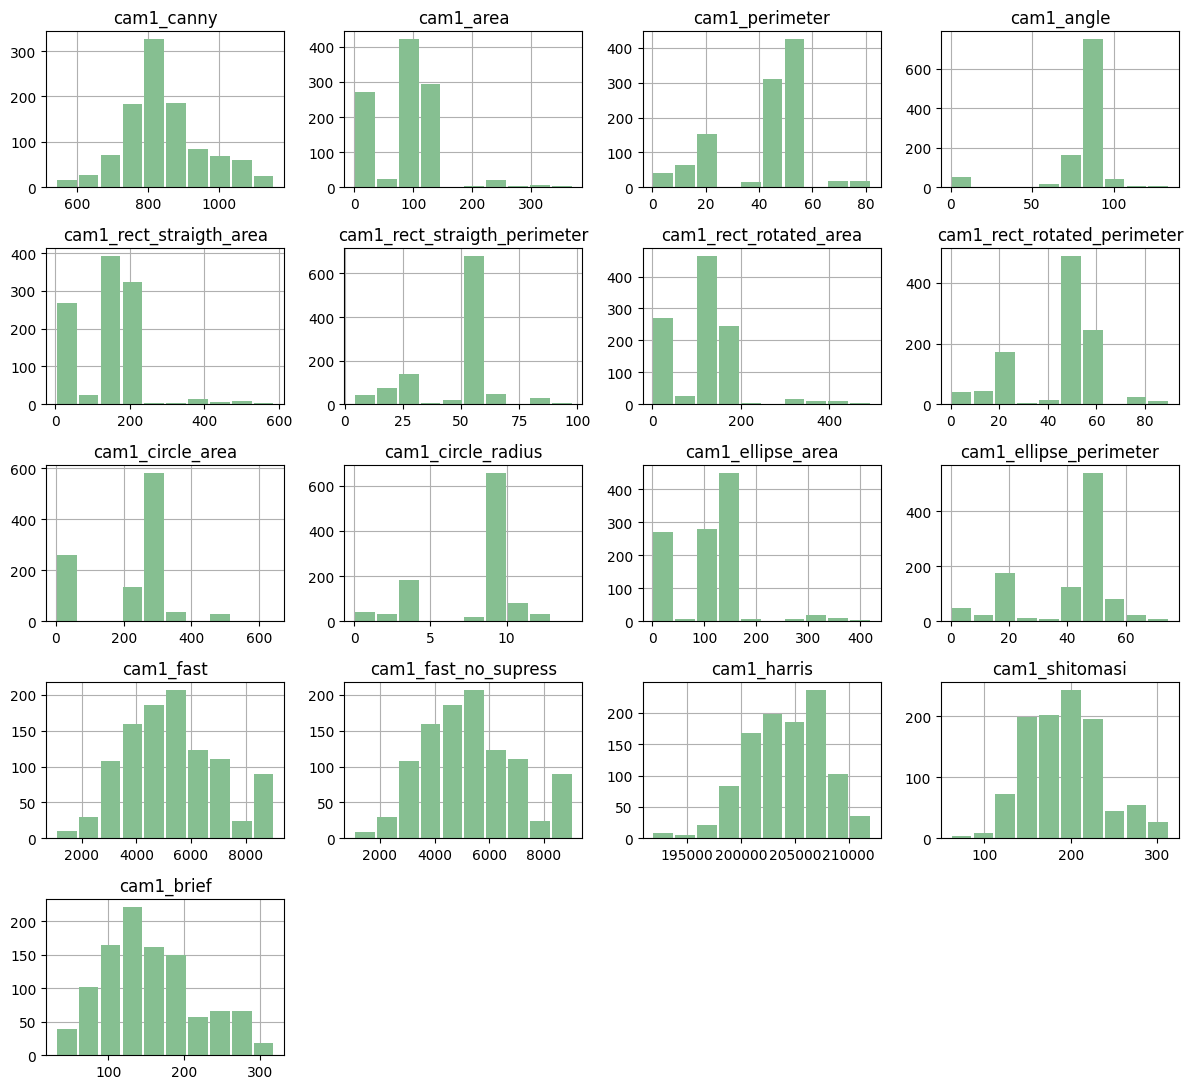

In [23]:
#Cam 1 features' distributions
ax = cam1.hist(figsize=(12, 11), color='#86bf91', zorder=2, rwidth=0.9)
plt.savefig('cam1_distri.png', transparent=True, bbox_inches='tight');
plt.tight_layout()

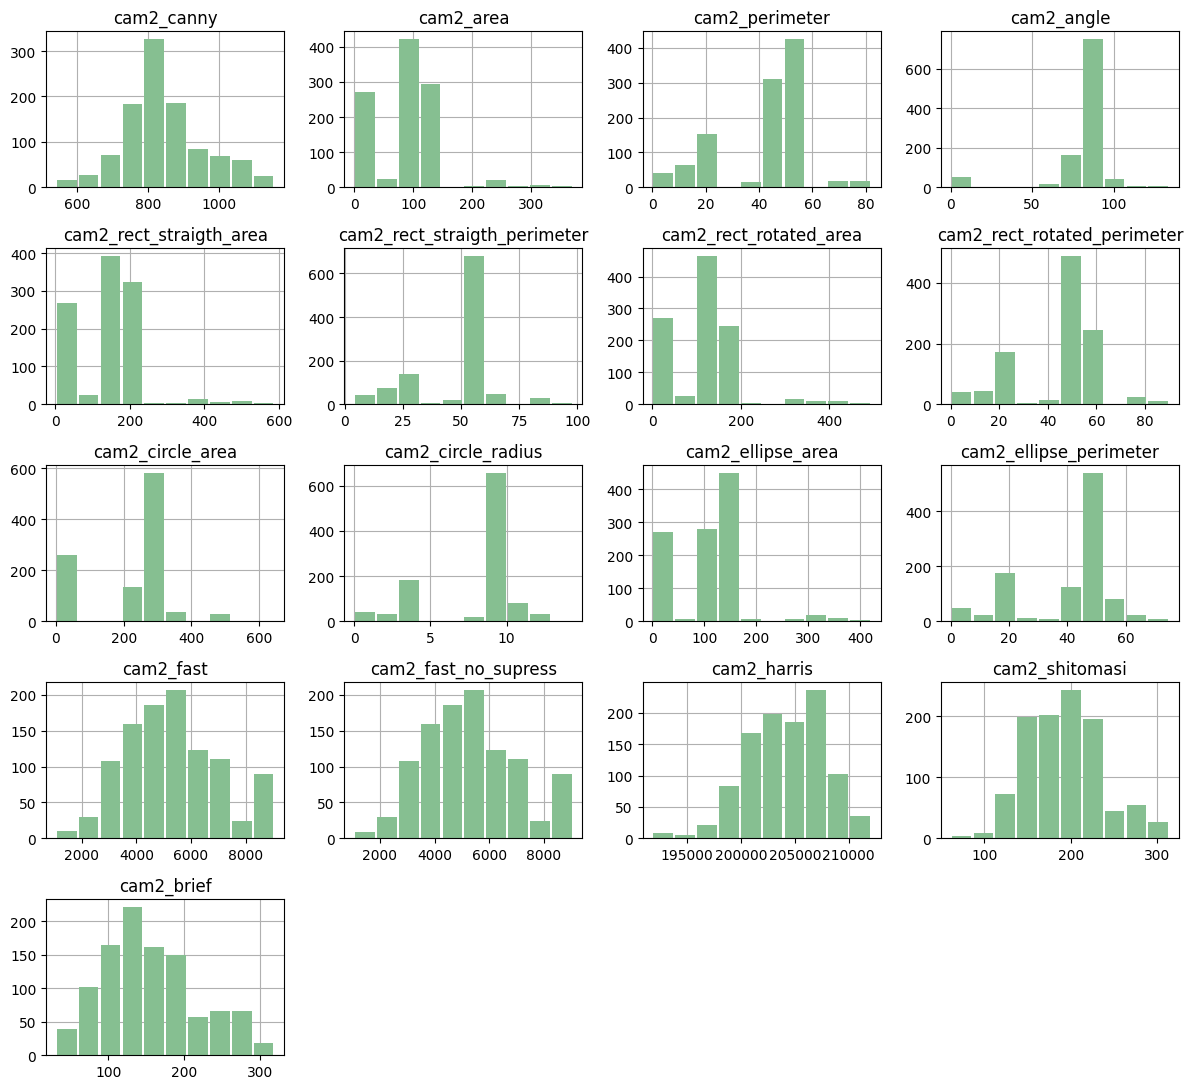

In [24]:
#Cam 2 features' distributions
ax = cam2.hist(figsize=(12, 11), color='#86bf91', zorder=2, rwidth=0.9)
plt.savefig('cam2_distri.png', transparent=True, bbox_inches='tight');
plt.tight_layout()

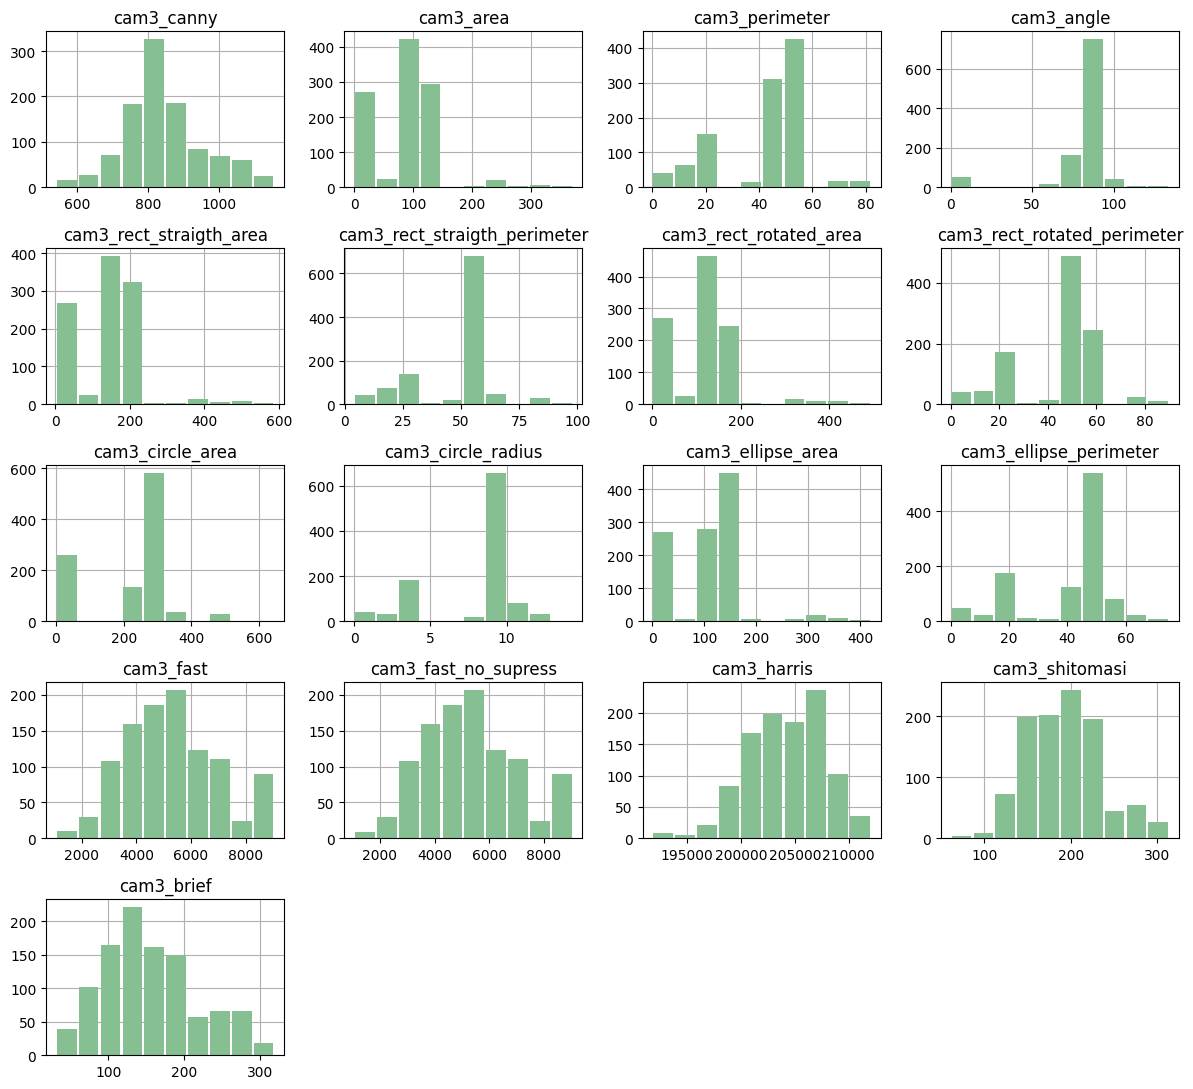

In [25]:
#Cam 3 features' distributions
ax = cam3.hist(figsize=(12, 11), color='#86bf91', zorder=2, rwidth=0.9)
plt.tight_layout()

## Removing highly correlated features

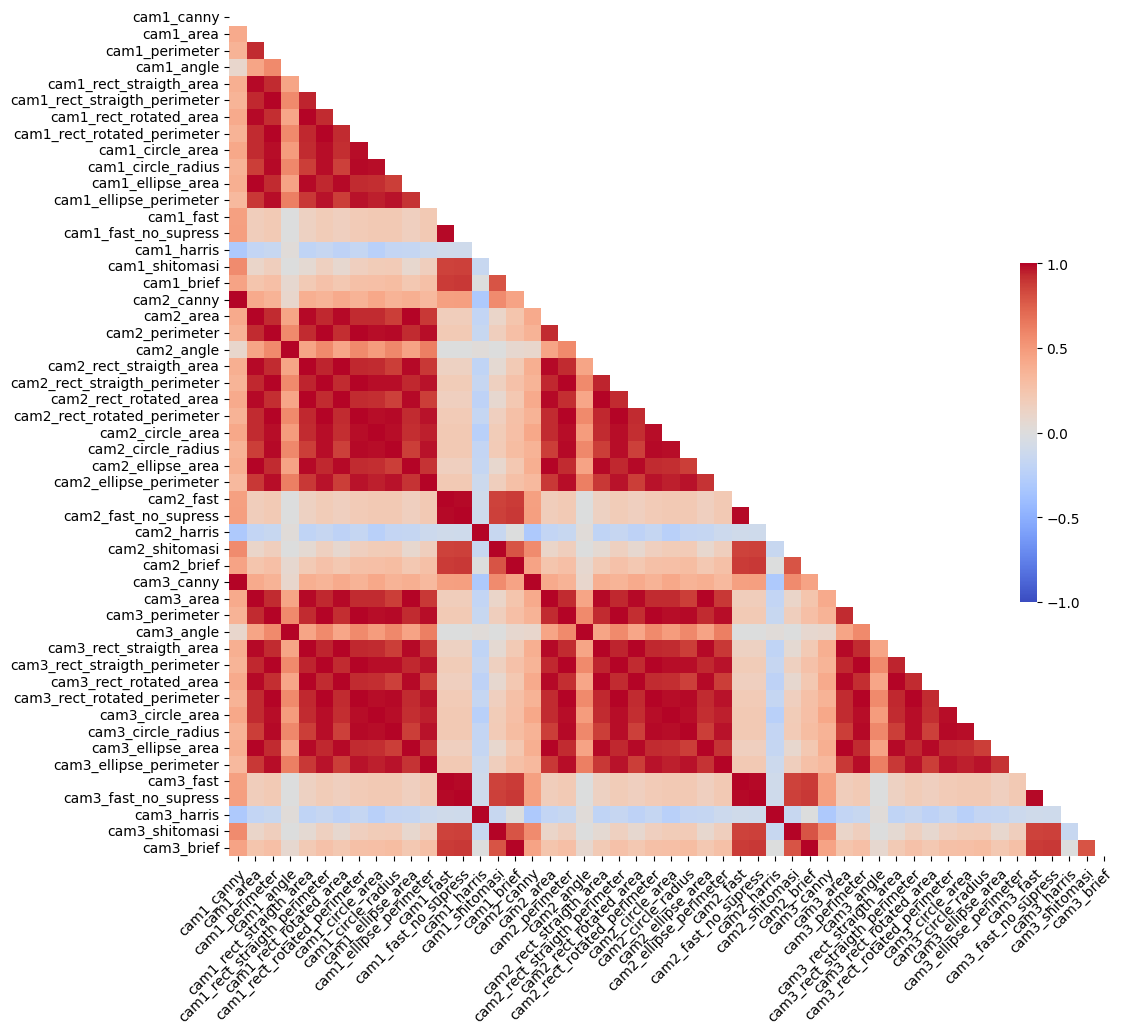

In [26]:
def plot_corr_matrix(inp_data, save=False, img_name = str):

    # Calculate pairwise-correlation
    matrix = inp_data.corr()
    
    # Create a mask to show only the lower triangular matrix
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    f = plt.figure(figsize=(12, 11))
    ax = sns.heatmap(matrix, mask=mask, cmap='coolwarm', annot=False, 
                     fmt='.1f', vmin=-1, vmax=1,
                     cbar_kws={"shrink": .4, "orientation": "vertical", "pad": -0.1})
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(-1, 1.1, 0.5))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10, ha='right',  rotation_mode='anchor')
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
    
    if save:
        plt.savefig(img_name, transparent=True, bbox_inches='tight')
      
    plt.show()
    
plot_corr_matrix(inp_data=X, save=True, img_name='corr_prev1.png')

In [27]:
corr_matrix = X.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(20)

cam2_ellipse_perimeter       cam3_ellipse_perimeter         1.0
cam1_perimeter               cam3_perimeter                 1.0
cam1_harris                  cam2_harris                    1.0
cam1_circle_radius           cam3_circle_radius             1.0
cam2_canny                   cam3_canny                     1.0
cam1_fast                    cam3_fast                      1.0
cam1_canny                   cam3_canny                     1.0
cam1_angle                   cam2_angle                     1.0
cam2_perimeter               cam3_perimeter                 1.0
cam2_brief                   cam3_brief                     1.0
cam1_rect_rotated_area       cam3_rect_rotated_area         1.0
cam1_fast_no_supress         cam2_fast_no_supress           1.0
cam2_circle_area             cam3_circle_area               1.0
cam2_rect_straigth_area      cam3_rect_straigth_area        1.0
cam2_shitomasi               cam3_shitomasi                 1.0
cam1_rect_rotated_perimeter  cam2_rect_r

In [28]:
remover = ['cam1_circle_area', 'cam2_circle_area', 'cam3_circle_area', 
           'cam1_rect_straigth_area', 'cam2_rect_straigth_area', 
           'cam1_fast_no_supress', 'cam2_fast_no_supress', 'cam3_fast_no_supress',
           'cam1_rect_rotated_area', 'cam2_rect_rotated_area']

X.drop(remover, axis=1, inplace=True)
X.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_perimeter,cam1_rect_rotated_perimeter,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,...,cam3_rect_straigth_perimeter,cam3_rect_rotated_area,cam3_rect_rotated_perimeter,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_harris,cam3_shitomasi,cam3_brief
0,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,1531.0,...,60.0,153.39,55.248914,9.708344,139.41,48.57,1531.0,199204.0,303.0,233.0
1,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,8654.0,...,60.0,153.39,55.248914,9.708344,139.41,48.57,8654.0,199204.0,303.0,233.0
2,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,8654.0,...,60.0,153.39,55.248914,9.708344,139.41,48.57,8654.0,199204.0,303.0,233.0
3,1035.0,0.0,0.00,0.0,4.0,0.000000,0.000100,0.00,0.00,8586.0,...,4.0,0.00,0.000000,0.000100,0.00,0.00,8586.0,198264.0,314.0,239.0
4,1035.0,0.0,0.00,0.0,4.0,0.000000,0.000100,0.00,0.00,8586.0,...,4.0,0.00,0.000000,0.000100,0.00,0.00,8586.0,198264.0,314.0,239.0


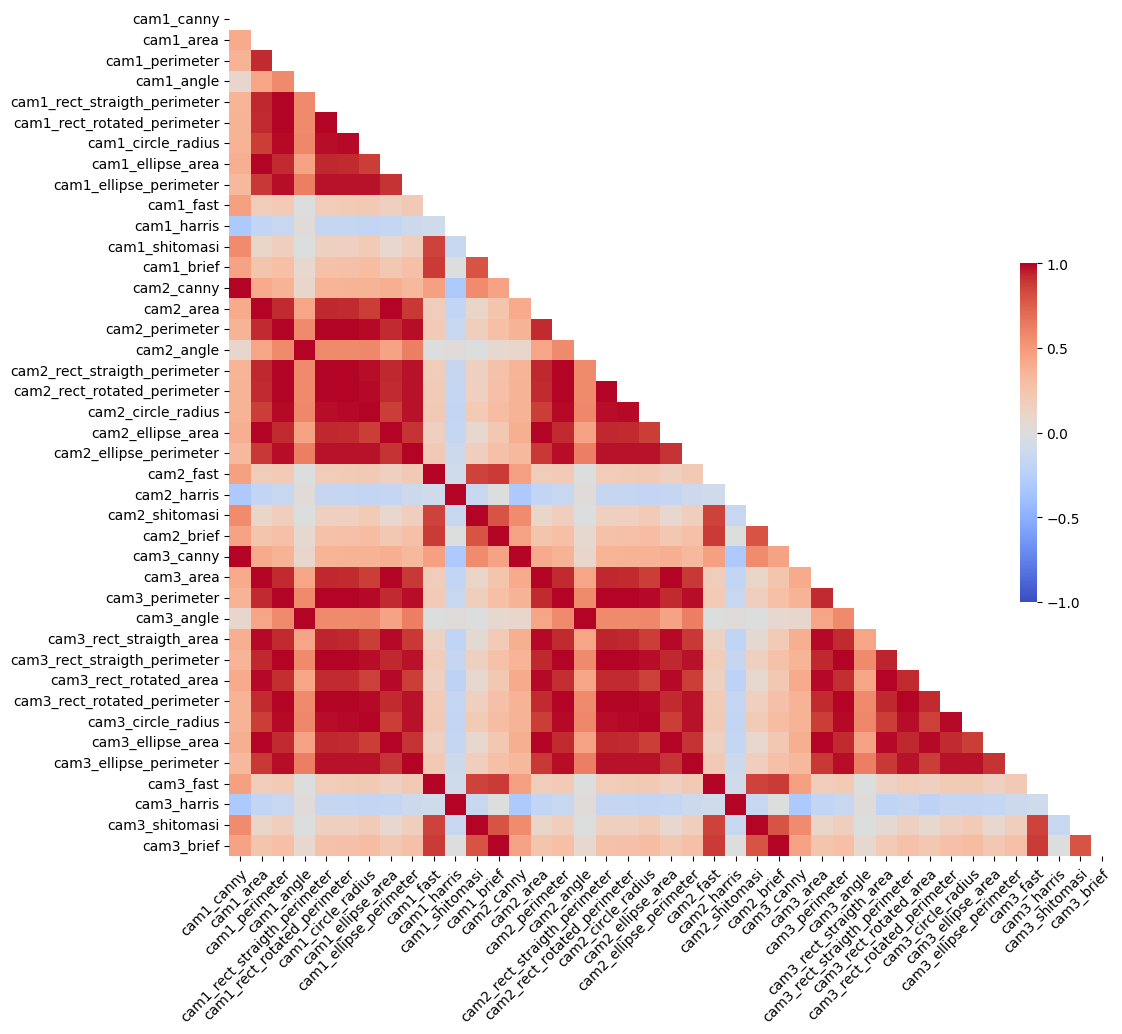

In [29]:
plot_corr_matrix(inp_data=X, save=True, img_name='corr_prev2.png')

`fast` and `brief` features are also highly correlated. We will, therefore, remove the one with lower variance.

In [30]:
analise_var = ['cam1_fast', 'cam1_brief', 'cam2_fast', 'cam2_brief', 'cam3_fast', 'cam3_brief']
X_scaled[analise_var].var()

cam1_fast     0.044043
cam1_brief    0.045847
cam2_fast     0.044043
cam2_brief    0.045847
cam3_fast     0.044043
cam3_brief    0.045847
dtype: float64

In [31]:
remover = ['cam1_brief', 'cam2_brief', 'cam3_brief']
X.drop(remover, axis=1, inplace=True)
X.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_perimeter,cam1_rect_rotated_perimeter,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,...,cam3_rect_straigth_area,cam3_rect_straigth_perimeter,cam3_rect_rotated_area,cam3_rect_rotated_perimeter,cam3_circle_radius,cam3_ellipse_area,cam3_ellipse_perimeter,cam3_fast,cam3_harris,cam3_shitomasi
0,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,1531.0,...,200.0,60.0,153.39,55.248914,9.708344,139.41,48.57,1531.0,199204.0,303.0
1,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,8654.0,...,200.0,60.0,153.39,55.248914,9.708344,139.41,48.57,8654.0,199204.0,303.0
2,1047.0,125.5,51.21,86.2,60.0,55.248914,9.708344,139.41,48.57,8654.0,...,200.0,60.0,153.39,55.248914,9.708344,139.41,48.57,8654.0,199204.0,303.0
3,1035.0,0.0,0.00,0.0,4.0,0.000000,0.000100,0.00,0.00,8586.0,...,1.0,4.0,0.00,0.000000,0.000100,0.00,0.00,8586.0,198264.0,314.0
4,1035.0,0.0,0.00,0.0,4.0,0.000000,0.000100,0.00,0.00,8586.0,...,1.0,4.0,0.00,0.000000,0.000100,0.00,0.00,8586.0,198264.0,314.0


In [32]:
remover = ['cam2_rect_rotated_perimeter', 'cam1_rect_rotated_perimeter']
X.drop(remover, axis=1, inplace=True)

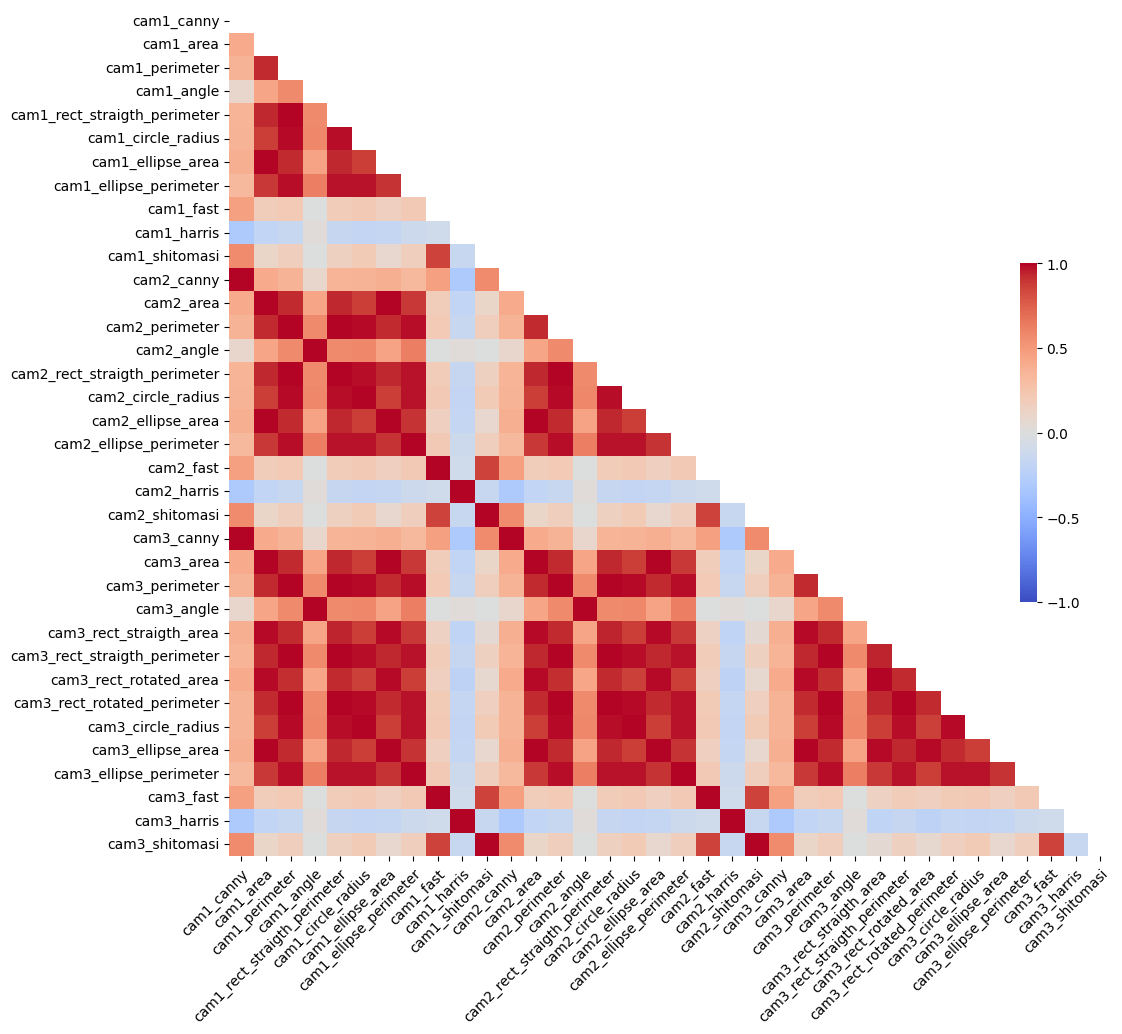

In [33]:
plot_corr_matrix(inp_data=X, save=True, img_name='corr_post.png')

In [34]:
corr_matrix = X.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

sol.head(8)

cam1_shitomasi  cam2_shitomasi    1.0
cam1_area       cam2_area         1.0
cam1_perimeter  cam2_perimeter    1.0
                cam3_perimeter    1.0
cam1_angle      cam2_angle        1.0
cam2_shitomasi  cam3_shitomasi    1.0
cam2_harris     cam3_harris       1.0
cam1_angle      cam3_angle        1.0
dtype: float64

In [35]:
n = 10

maior_r = list(set(sol.head(n).keys().get_level_values(0)) \
.union(set(sol.head(n).keys().get_level_values(1))))

maior_r

['cam1_angle',
 'cam2_ellipse_perimeter',
 'cam3_harris',
 'cam2_shitomasi',
 'cam3_angle',
 'cam1_shitomasi',
 'cam1_area',
 'cam3_fast',
 'cam3_ellipse_perimeter',
 'cam1_perimeter',
 'cam3_shitomasi',
 'cam2_fast',
 'cam2_angle',
 'cam2_perimeter',
 'cam2_harris',
 'cam3_perimeter',
 'cam2_area']

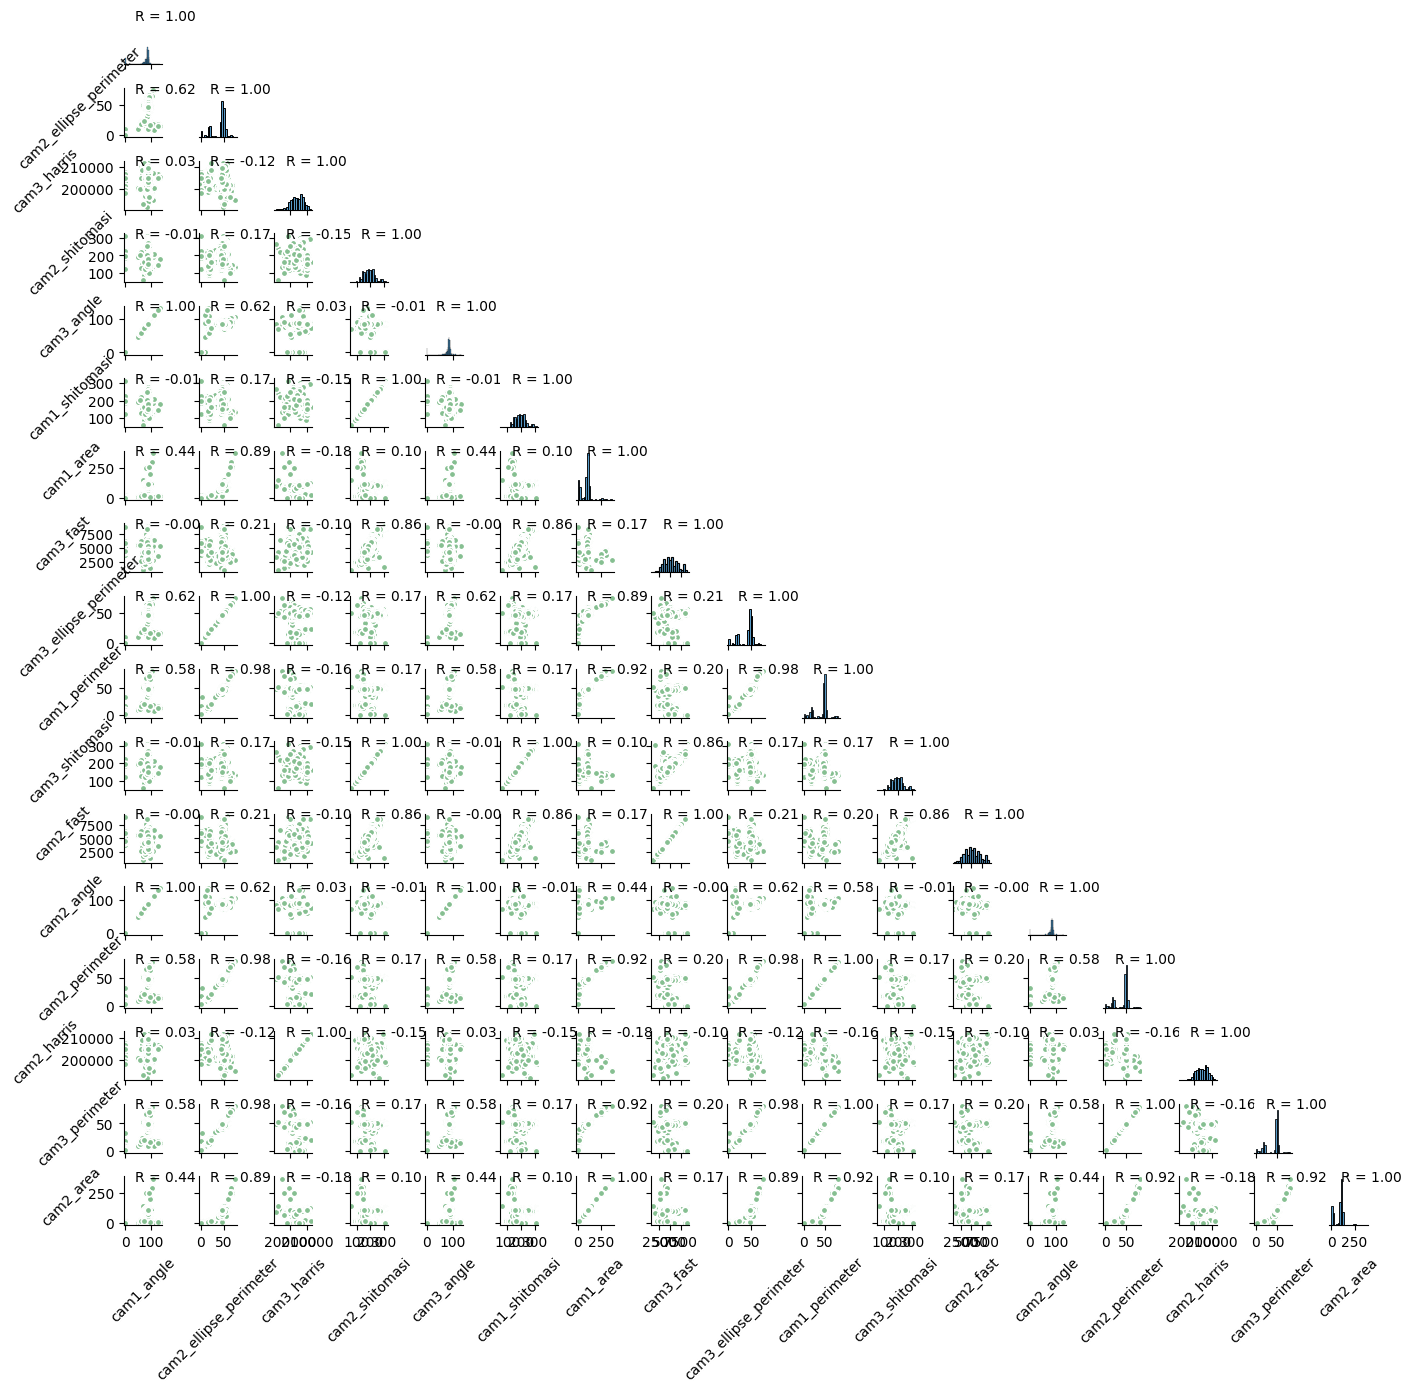

In [36]:
def corrfunc(x, y, **kws):
    (r, p) = ss.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("R = {:.2f} ".format(r),
                xy=(.3, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(X[maior_r],
                     plot_kws=dict(s=20, color='#86bf91', linewidth=1), corner=True, diag_kind='hist')

for ax in g.axes.flatten():
    if ax:   
        ax.set_xlabel(ax.get_xlabel(), rotation=45, labelpad=4)
        ax.set_ylabel(ax.get_ylabel(), rotation=45, ha="left", labelpad=8)

g.map(corrfunc)
g.fig.set_size_inches(14, 14)
plt.tight_layout()
plt.show()

## output data analysis

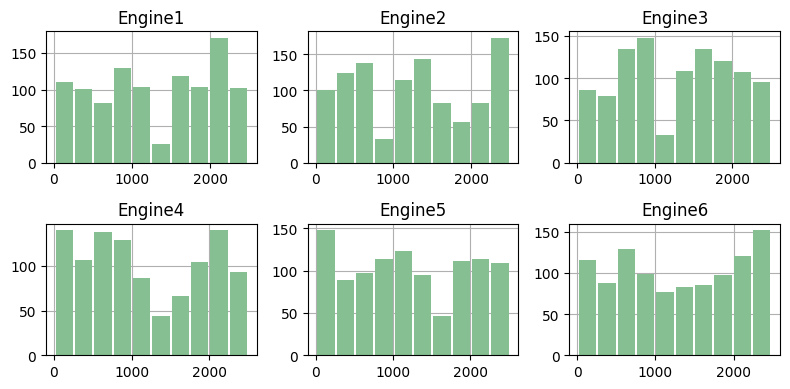

In [37]:
ax = Y.hist(figsize=(8, 4), color='#86bf91', zorder=2, rwidth=0.9, layout = (2, 3))
plt.tight_layout()
plt.savefig('target.png', transparent=True, bbox_inches='tight');

In [38]:
#Unique values presented in each output feature
for column in Y.columns:
    print(f"{column}: {Y[column].nunique()}")
    print("===========================================")

Engine1: 135
Engine2: 137
Engine3: 126
Engine4: 133
Engine5: 131
Engine6: 138


In [39]:
#Joining the explainable variables with the targets based on the instances indexes
df_final = X.join(Y)

df_final.reset_index(drop=True, inplace=True)
print(path + 'output/preprocessed.csv')
df_final.to_csv(path + 'output/preprocessed.csv', index=False)

/content/gdrive/MyDrive/CIMATEC/MCTI/BOLSA/SoftArm/dataset/EDA/output/preprocessed.csv


In [41]:
# showing what was written to csv
df_final.head(3)


,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_perimeter,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,cam1_harris,...,cam3_ellipse_perimeter,cam3_fast,cam3_harris,cam3_shitomasi,Engine1,Engine2,Engine3,Engine4,Engine5,Engine6
0,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,1531.0,199204.0,...,48.57,1531.0,199204.0,303.0,10,10,10,10,10,10
1,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10,10,10,10,10,10
2,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10,10,10,10,10,10
